## Estimating Life expectency of Age group <1 year old in USA in the Year 2010

First we deal with the livestock data: the data collection, data visualization etc. Then merge it with the life expectency data to apply machine learning regression. 

### Lets begin with the livestock

There are altogether 8 species. First I take into consideration only the chickens data from 2010. The source of this data is: (https://www.nature.com/articles/sdata2018227). Go to "Data Records" in the paper and then click "7" twice in the "Data Citation" for data on chickens. On the right, click the highlighted link. The link will lead to the data and metadata of the species.

The file "5_Ch_2010_Da.tif" consists of the data. It is a raster data with the resolution of 5 min of arc or ~ 10km at the equator (0.083333 decimal degrees). Basically a grid. The png file shows the distribution of the chickens on a global scale. 

Lets first recreate the data.


In [1]:
## lets import the packages

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr
from rasterstats import zonal_stats
import pandas as pd


In [2]:
## Define relative path to file. Note that the use of forward and backslash can cause problems 
## when dealing with different operating system. So we will use the os.path.join method to get
## to the directory.
 
DATA_PATH = os.path.join("Data", "5_Ch_2010_Da.tif")

initial_arr= rxr.open_rasterio(DATA_PATH)
initial_arr


<xarray.DataArray (band: 1, y: 2160, x: 4320)>
[9331200 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  4395041401.872276
    STATISTICS_MAXIMUM:      10530973.506529
    STATISTICS_MEAN:         9529.6132740367
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       66295.108430956
    _FillValue:              -1.7e+308
    scale_factor:            1.0
    add_offset:              0.0

We can see that there are 3 coordinates: band, y and x. Since, its a global data, the bounds of x and y coordinate being the longitude and latitude is over the entire globe. As mentioned in the paper, raster layer is 4,320 X 2,160 pixel; which is shown above.

In [3]:
## lets look at the coordinate referencing system (CRS) and spatial extent of the data


print("The CRS is:", initial_arr.rio.crs)
print("The spatial extent is:", initial_arr.rio.bounds())


The CRS is: EPSG:4326
The spatial extent is: (-180.0, -90.0, 179.99999999999994, 90.0)


In raster data, a value is assigned when there is no data. This value is usually very small or large. Lets look at what that value is in this grid.

In [4]:
# View no data value

print("The no data value is:", initial_arr.rio.nodata)

## lets also look at the minimum and maximum value of the data

print("The minimum raster value is: ", np.nanmin(initial_arr.values))
print("The maximum raster value is: ", np.nanmax(initial_arr.values))

The no data value is: -1.7e+308
The minimum raster value is:  -1.7e+308
The maximum raster value is:  10530973.506528964


In [5]:
## lets remove the no data value from the data

cleaned_arr= rxr.open_rasterio(DATA_PATH, masked=True)
cleaned_arr

<xarray.DataArray (band: 1, y: 2160, x: 4320)>
[9331200 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  4395041401.872276
    STATISTICS_MAXIMUM:      10530973.506529
    STATISTICS_MEAN:         9529.6132740367
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       66295.108430956
    scale_factor:            1.0
    add_offset:              0.0

In [6]:
## lets look at the shape of the data array

cleaned_arr.shape

(1, 2160, 4320)

In [7]:
## the dimension: 1 will be removed as we know that this raster has only a single band.

cleaned_arr = rxr.open_rasterio(DATA_PATH, masked=True).squeeze()
# Notice there are now only 2 dimensions to your array
cleaned_arr.shape

(2160, 4320)

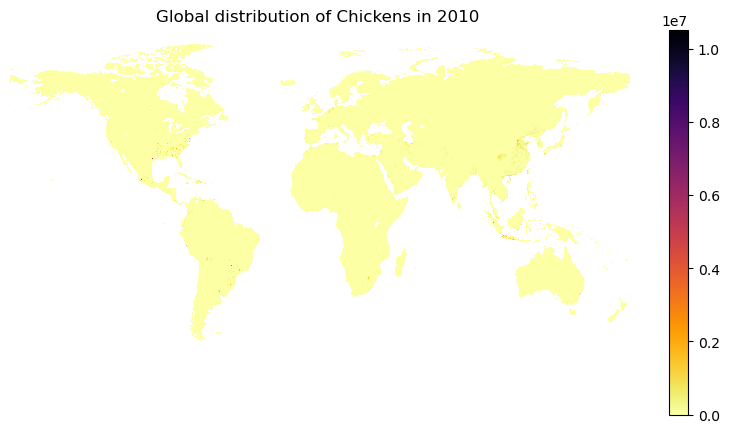

In [8]:
## lets plot the data

f, ax = plt.subplots(figsize=(10, 5))
cleaned_arr.plot(cmap="inferno_r",
                 ax=ax)
ax.set_title("Global distribution of Chickens in 2010 ")
ax.set_axis_off()
plt.show()

# The original data looks like this
![Original Data](./Data/2_Ch_2010_Da.png)



### Note that in the original raster, the color pallette is not continous but grouped. When we look at the last one, the value 10,000 between  1,000,000 is represented by the same color. 

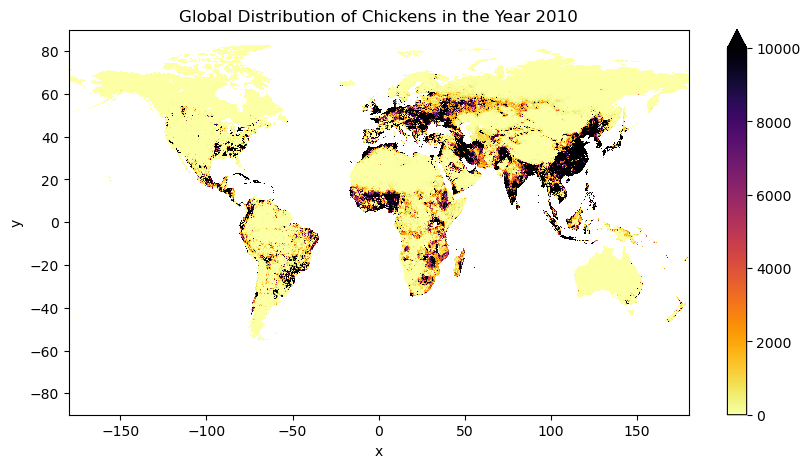

In [9]:
## lets change the maximum value in our graph so that we can see some distribution in the data.

f, ax = plt.subplots(figsize=(10, 5))
cleaned_arr.plot(cmap="inferno_r",
                 ax=ax,vmin=0, vmax=10_000)   ## setting vmin=0 does not matter as the minimum value is 0.
ax.set_title("Global Distribution of Chickens in the Year 2010")

#ax.set_axis_off()

plt.show()

## changnig projection, adding shapefiles of the coutries
## and adding graticules will make the map looks like the original one.

In [10]:
## lets clip the raster only to that of USA

usa_arr=cleaned_arr.rio.clip_box(
    minx=-125,
    miny=23,
    maxx=-65,
    maxy=50,
)

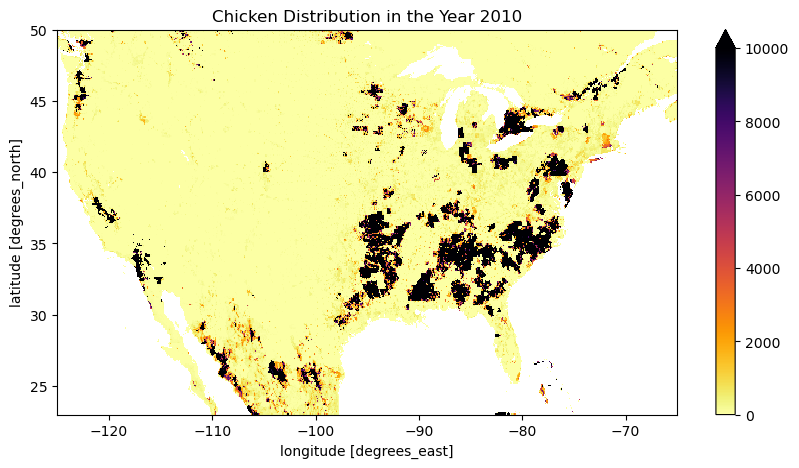

In [11]:
## lets plot the region focusing in USA

f, ax = plt.subplots(figsize=(10, 5))
usa_arr.plot(cmap="inferno_r",
                 ax=ax,vmin=0, vmax=10_000) 
ax.set_title("Chicken Distribution in the Year 2010")

#ax.set_axis_off()

plt.show()


In [12]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("Shapefiles",
                               "State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)


The CRS of the SHAPE file is: EPSG:4269


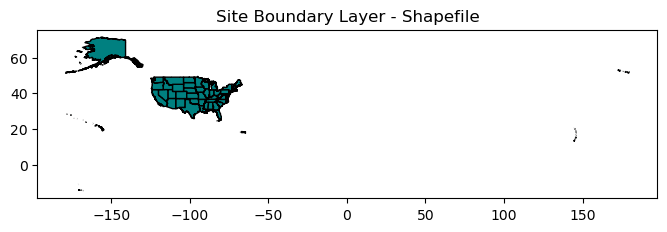

In [13]:
## lets view the shapefile. We will trim it later

f, ax = plt.subplots(figsize=(8,4))
state_shape.plot(color='teal', edgecolor='black', ax=ax)
ax.set(title="Site Boundary Layer - Shapefile")
plt.show()

The CRS of the raster and that of the Shape file is different. Despite, that the map is accurate. May be because the difference between the CRS is small. One can transform the CRS of the shape file, but I am going to keep it the same.

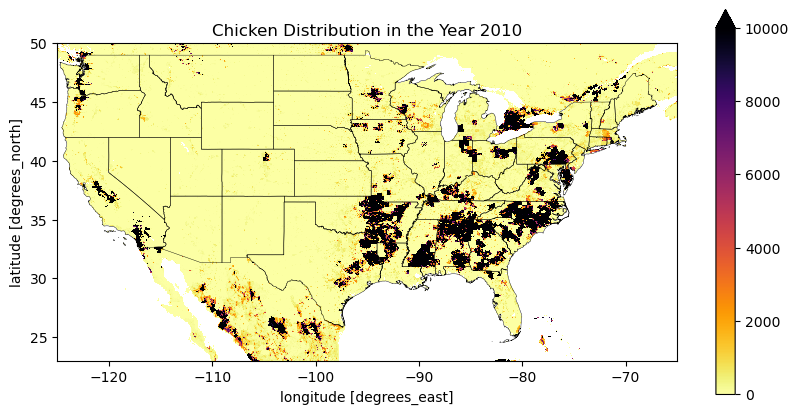

In [14]:
## overlay the raster and the shapefile

fig, ax = plt.subplots(figsize=(10, 5))

usa_arr.plot(cmap="inferno_r",
                 ax=ax,vmin=0, vmax=10_000)

state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.3)

ax.set_axis_on()
ax.set_title("Chicken Distribution in the Year 2010")

plt.show()

In [15]:
## lets clip the raster with shape file so that we see only the values in the shape file

clipped = usa_arr.rio.clip(state_shape.geometry.values, state_shape.crs, drop=False, invert=False)

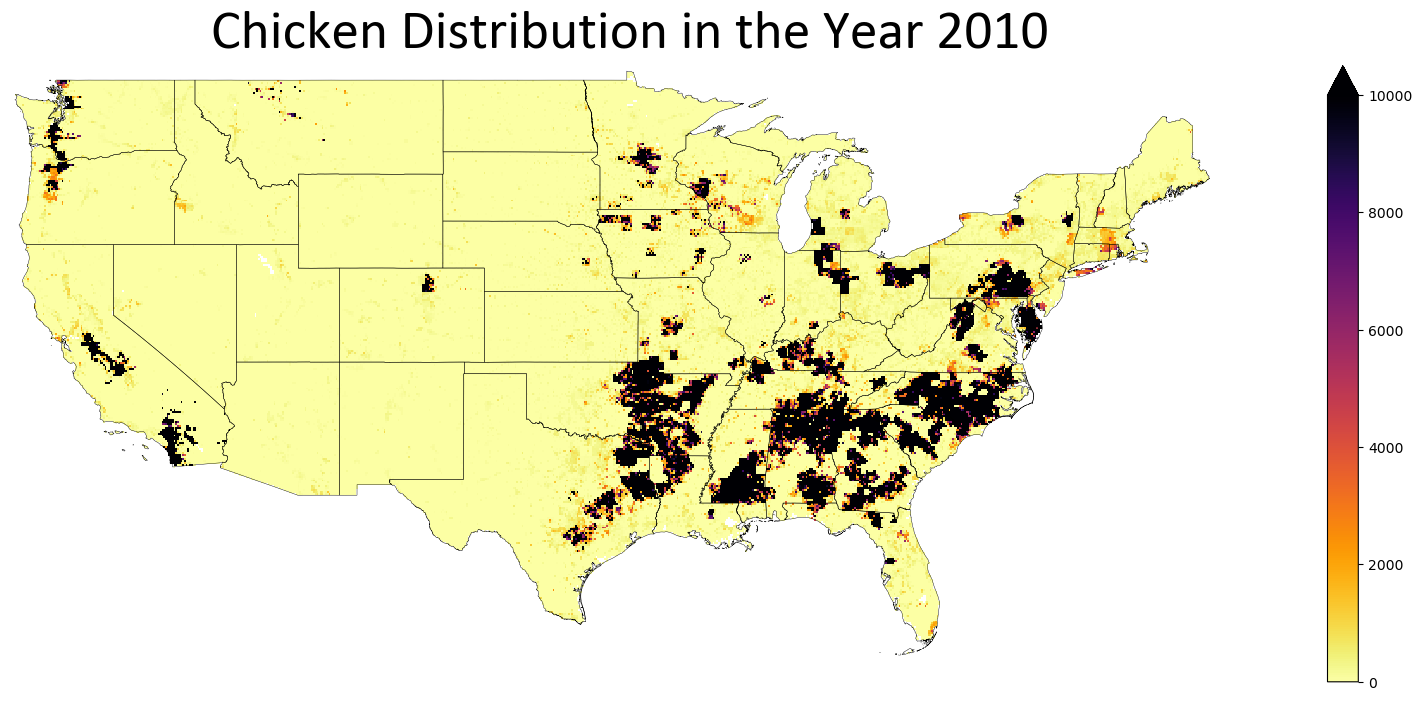

In [16]:
## lets plot the clipped data

fig, ax = plt.subplots(figsize=(20, 10))

clipped.plot(cmap="inferno_r", ax=ax,vmin=0, vmax=10_000,cbar_kwargs={'shrink': 0.80})

state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.3)

ax.set_axis_off()
ax.set_title("Chicken Distribution in the Year 2010", fontsize=40,fontname="Calibri")


plt.show()

# Now that we have plotted the data. We will now extract the values of pixel that a shape file covers

In [17]:
## lets load the grid

CH_PATH=os.path.join("Data", "5_Ch_2010_Da.tif")

raster_data = CH_PATH
raster_data

'Data\\5_Ch_2010_Da.tif'

In [18]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("Shapefiles", "County_shapefile",'gz_2010_us_050_00_500k.shp')
county_shp = gpd.read_file(SHAPE_PATH)
county_shp

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."
...,...,...,...,...,...,...,...
3216,0500000US72131,72,131,San Sebastián,Muno,70.423,"POLYGON ((-66.90748 18.25314, -66.90739 18.253..."
3217,0500000US72133,72,133,Santa Isabel,Muno,34.023,"POLYGON ((-66.37968 17.94398, -66.38029 17.943..."
3218,0500000US72137,72,137,Toa Baja,Muno,23.241,"MULTIPOLYGON (((-66.13957 18.46232, -66.13956 ..."
3219,0500000US72139,72,139,Trujillo Alto,Muno,20.764,"POLYGON ((-66.02917 18.37590, -66.02828 18.376..."


### The next cell will extract the value of the shape file that covers the raster.

I see there are two ways to extract the value:

(i) Find the centroid of the polygon which can be done using geopandas. Create a column which has the centroid of the polygon. There are several ways that can be found online to assign the Point coordinate the value of the raster. Then the shape file will have the value of that point coordinate. 

(ii) Find the raster that a shape file covers and then find the mean of the raster. 

Here the second option is chosen. The package used is rasterstats. The documentation shows how the value can be obtained as dictionary.  https://pythonhosted.org/rasterstats/

In [19]:
## source: https://gis.stackexchange.com/questions/447350/extract-the-raster-values-for-geometry-using-python

county_shp["Chickens"] = [x["mean"] for x in zonal_stats(vectors=county_shp["geometry"],
                                                           raster=raster_data, 
                                                           stats="mean")]

In [20]:
county_shp

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Chickens
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",231308.103464
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",466236.359207
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",23.203793
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",133533.887324
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",402821.825837
...,...,...,...,...,...,...,...,...
3216,0500000US72131,72,131,San Sebastián,Muno,70.423,"POLYGON ((-66.90748 18.25314, -66.90739 18.253...",329.541799
3217,0500000US72133,72,133,Santa Isabel,Muno,34.023,"POLYGON ((-66.37968 17.94398, -66.38029 17.943...",0.000000
3218,0500000US72137,72,137,Toa Baja,Muno,23.241,"MULTIPOLYGON (((-66.13957 18.46232, -66.13956 ...",159.109919
3219,0500000US72139,72,139,Trujillo Alto,Muno,20.764,"POLYGON ((-66.02917 18.37590, -66.02828 18.376...",NaN


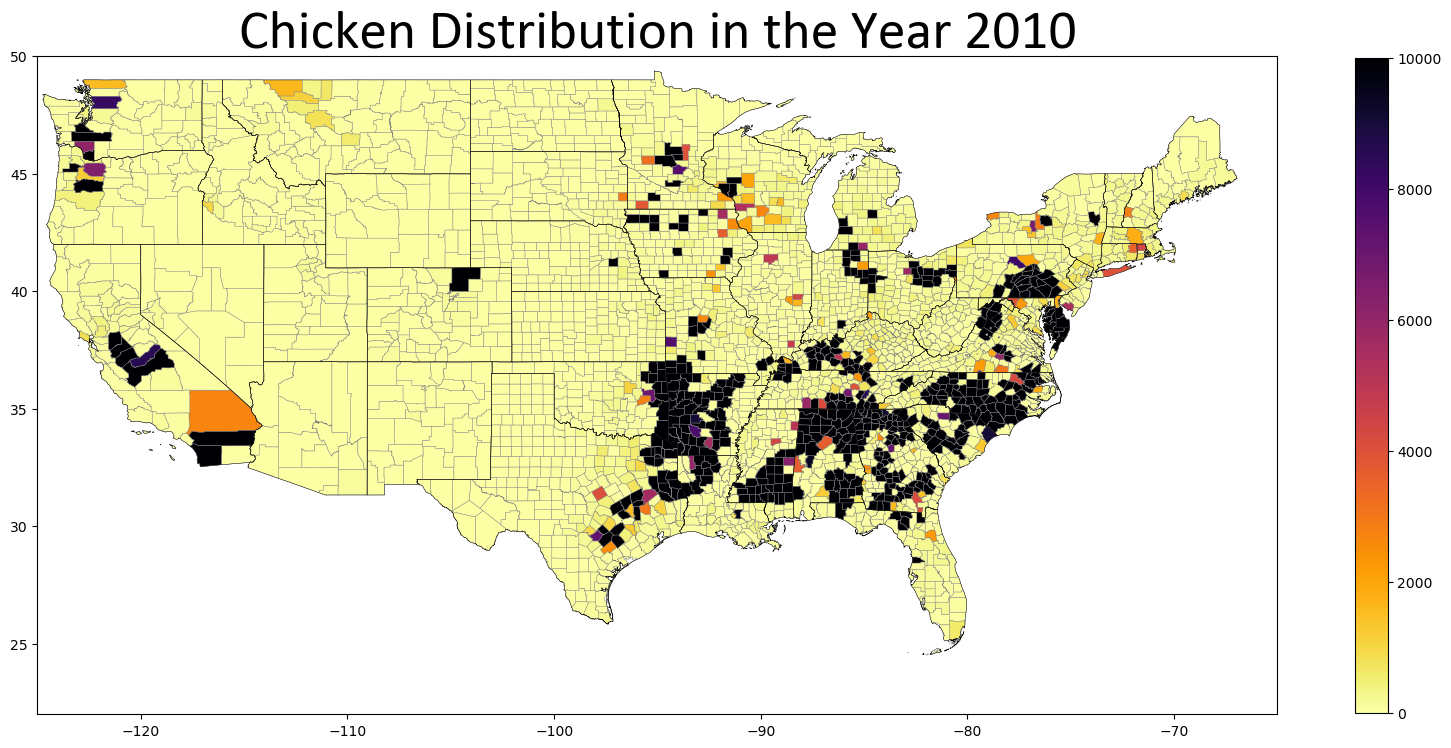

In [21]:
# create an Axes object and plot the map

fig, ax = plt.subplots(figsize=(20, 10))

county_shp.plot(ax=ax, column='Chickens',legend=True,vmin=0, vmax=10_000,edgecolor='grey',
                                              linewidth=0.3,cmap='inferno_r', 
                                               legend_kwds={"shrink":0.85})

## overlay the state shapefile

state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.3)

ax.set_xlim(-125, -65)
ax.set_ylim(22, 50)
ax.set_title("Chicken Distribution in the Year 2010", fontsize=40,fontname="Calibri")
plt.show()


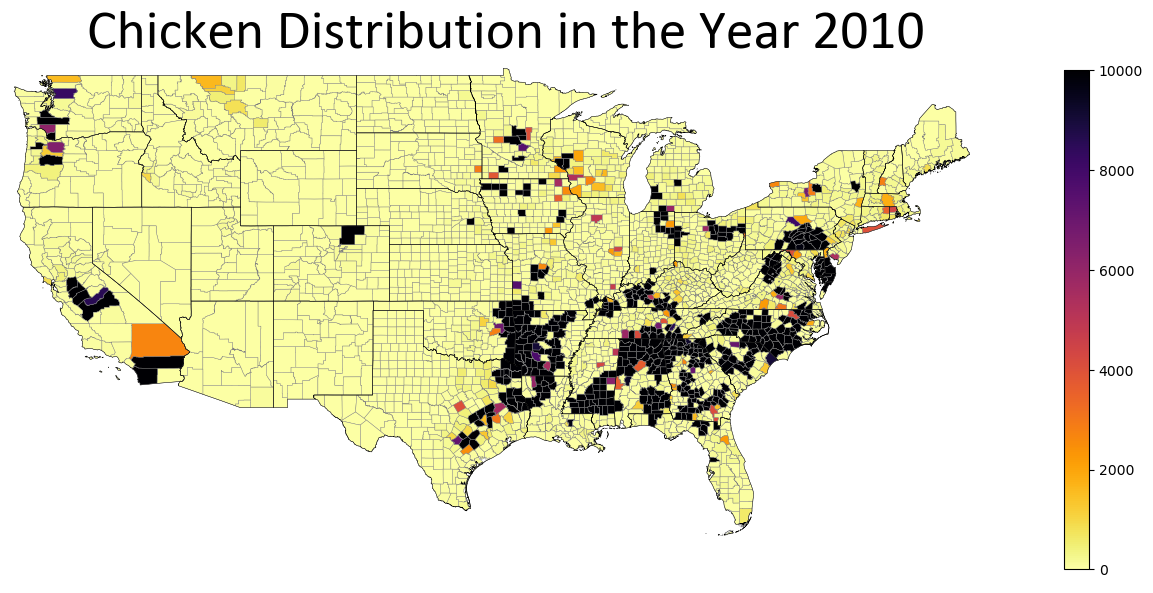

In [22]:
# lets plot the same object but by preserving the aspect ratio 
## so that the figure does not look stretched

fig, ax = plt.subplots()

zoom = 2.5
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)


county_shp.plot(ax=ax, column='Chickens',legend=True,vmin=0, vmax=10_000,edgecolor='grey',
                                              linewidth=0.3,cmap='inferno_r', 
                                               legend_kwds={"shrink":0.54})

## overlay the state shapefile

state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.3)

ax.set_xlim(-125, -65)
ax.set_ylim(22, 50)
ax.set_axis_off()
ax.set_title("Chicken Distribution in the Year 2010", fontsize=40,fontname="Calibri")
plt.show()

#### Now that we have a DataFrame in terms County and corresponding number of livestock. We will need the DataFrame in terms of county and corressponding mean life expectency.

Use the Single_Year.ipynb notebook and get the total life expectency of age group <1 year old of the year 2010 by using the file "IHME_USA_COD_COUNTY_RACE_ETHN_2000_2019_LT_2010_ALL_BOTH_Y2023M06D12". Get the csv file consisting of the total life expectency of age group < 1 year old and keep it in this folder and load it as shown below.

In [23]:
df1 = pd.read_csv('LE_2010.csv')
df1

,Unnamed: 0,location_name,fips,year,MeanLifeExpectency
0,228,Autauga County (Alabama),1001,2010,75.728489
1,234,Baldwin County (Alabama),1003,2010,77.826608
2,240,Barbour County (Alabama),1005,2010,75.841973
3,246,Bibb County (Alabama),1007,2010,73.705432
4,252,Blount County (Alabama),1009,2010,75.753407
...,...,...,...,...,...
3122,363426,Sweetwater County (Wyoming),56037,2010,77.582422
3123,363432,Teton County (Wyoming),56039,2010,83.771012
3124,363438,Uinta County (Wyoming),56041,2010,77.836526
3125,363444,Washakie County (Wyoming),56043,2010,78.674180


In [24]:
## lets delete these columns. 
df1 = df1.drop([
 'Unnamed: 0',              
 'year'], axis=1)

df1

,location_name,fips,MeanLifeExpectency
0,Autauga County (Alabama),1001,75.728489
1,Baldwin County (Alabama),1003,77.826608
2,Barbour County (Alabama),1005,75.841973
3,Bibb County (Alabama),1007,73.705432
4,Blount County (Alabama),1009,75.753407
...,...,...,...
3122,Sweetwater County (Wyoming),56037,77.582422
3123,Teton County (Wyoming),56039,83.771012
3124,Uinta County (Wyoming),56041,77.836526
3125,Washakie County (Wyoming),56043,78.674180


In [25]:
df1.dtypes

location_name          object
fips                    int64
MeanLifeExpectency    float64
dtype: object

In [30]:
df2=pd.DataFrame(county_shp)
df2 = df2.drop([
 'GEO_ID',              
 'CENSUSAREA','geometry'], axis=1)

df2


,STATE,COUNTY,NAME,LSAD,Chickens
0,01,029,Cleburne,County,231308.103464
1,01,031,Coffee,County,466236.359207
2,01,037,Coosa,County,23.203793
3,01,039,Covington,County,133533.887324
4,01,041,Crenshaw,County,402821.825837
...,...,...,...,...,...
3216,72,131,San Sebastián,Muno,329.541799
3217,72,133,Santa Isabel,Muno,0.000000
3218,72,137,Toa Baja,Muno,159.109919
3219,72,139,Trujillo Alto,Muno,NaN


In [31]:
df2.dtypes

STATE        object
COUNTY       object
NAME         object
LSAD         object
Chickens    float64
dtype: object

In [33]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum

df2['fips']=df2['STATE']+df2['COUNTY']
df2.dtypes

STATE        object
COUNTY       object
NAME         object
LSAD         object
Chickens    float64
fips         object
dtype: object

In [35]:
## convert the data type
df2['fips']=df2['fips'].astype(str).astype(int)
df2.dtypes

STATE        object
COUNTY       object
NAME         object
LSAD         object
Chickens    float64
fips          int32
dtype: object

In [36]:
## lets merge the dataframe
final_df=pd.merge(df1,df2, how='left', on=['fips'])
final_df

,location_name,fips,MeanLifeExpectency,STATE,COUNTY,NAME,LSAD,Chickens
0,Autauga County (Alabama),1001,75.728489,01,001,Autauga,County,58.454196
1,Baldwin County (Alabama),1003,77.826608,01,003,Baldwin,County,28.412358
2,Barbour County (Alabama),1005,75.841973,01,005,Barbour,County,136425.718220
3,Bibb County (Alabama),1007,73.705432,01,007,Bibb,County,54.231019
4,Blount County (Alabama),1009,75.753407,01,009,Blount,County,490520.990907
...,...,...,...,...,...,...,...,...
3122,Sweetwater County (Wyoming),56037,77.582422,56,037,Sweetwater,County,1.158933
3123,Teton County (Wyoming),56039,83.771012,56,039,Teton,County,0.877619
3124,Uinta County (Wyoming),56041,77.836526,56,041,Uinta,County,5.169807
3125,Washakie County (Wyoming),56043,78.674180,56,043,Washakie,County,3.279337
